In [25]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
from qutip import *

from qiskit.circuit import Parameter, Gate
from qiskit.quantum_info import Operator
from qiskit.circuit.library import iSwapGate
from qiskit.circuit.library import SwapGate
from qiskit.visualization import array_to_latex
import array_to_latex as a2l
from IPython.display import display, Markdown, Latex

Lets run a hamiltonian simulation for 2 qubits that don't expirience any interaction or coupling. The hamiltonian for each qubit is given by:

$$H = \frac{\delta}{2} \sigma_z + \frac{\Omega}{2} \sigma_x \$$

In my attached notes I calculate the time evolved matrix of this. We can write the single qubit time evolved hamiltonian U(t) as:

$$U(t) = R_{z}(\delta t) R_{x}(\Omega t) $$

lets go over an example where t=2.25sec and r=16. This makes our error $\epsilon$ equal to:

$$ \epsilon = \frac{t^2}{r} = \frac{2.25^2}{25} = 0.2025 $$

This makes our $\epsilon$ error approximately 20%, which should be plenty acceptable for our experiment.

First, let's build our U(t) for our hamiltonian simulation for $\delta$ = 0.5 and $\Omega$ = $2\pi$

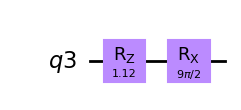

In [12]:
t = 2.25
delta = 0.5
Omega = 2*np.pi

qr = QuantumRegister(1)
qc = QuantumCircuit(qr, name="U(t={})".format(t))

qc.rz(delta * t, 0)
qc.rx(Omega * t, 0)
U_t = qc.to_gate()
qc.draw(output='mpl')

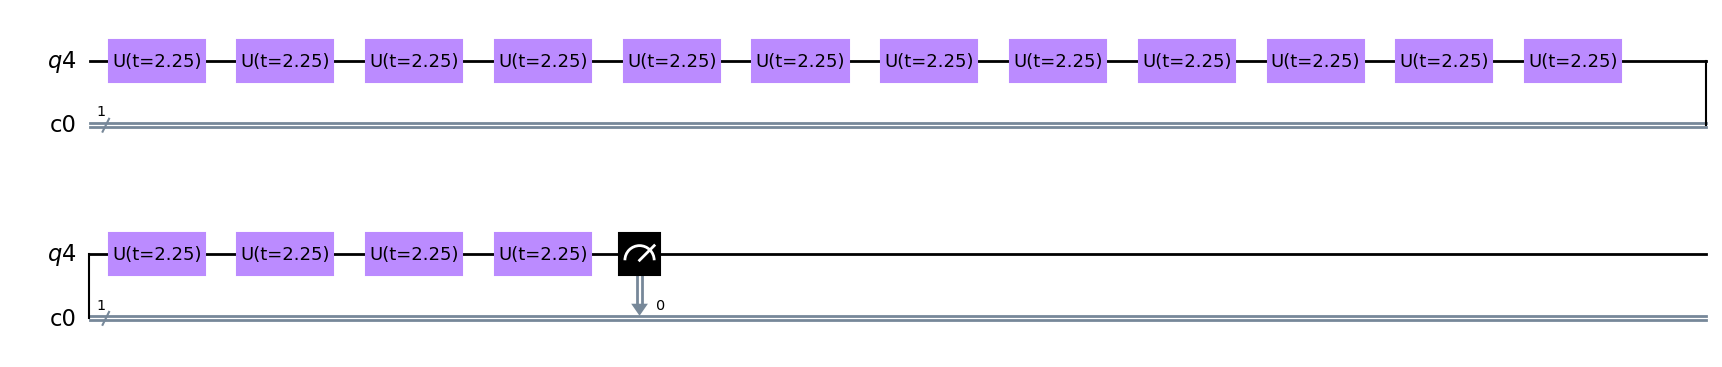

In [13]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)

r = 16
for i in range(r):
    qc.append(U_t, [0])
qc.measure(qr[0], cr[0])

qc.draw(output='mpl')

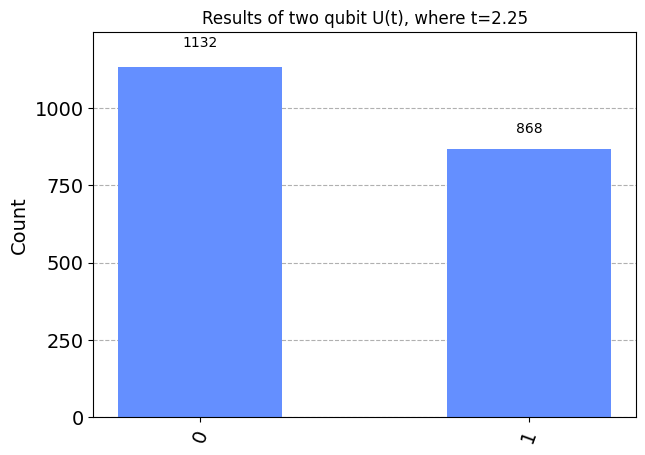

In [14]:
sim = Aer.get_backend('aer_simulator')
shots = 2000
results = execute(qc, backend=sim, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts, title="Results of two qubit U(t), where t={}".format(t))

Here, we see the simulated qubit is in a superposition between 0 and 1 at t=2.25 seconds

$$ U_{Eff}(t) = cos(\frac{g^2}{4\delta}t) \mathbb{I} + \mathbb{i}sin(\frac{g^2}{4\delta}t)(\sigma_{+}\mathop{\otimes}\sigma_{-} + \sigma_{-}\mathop{\otimes}\sigma_{+})  $$

Let's take this Hamiltonian and see what it would be for $g^2=\pi$, $\delta=0.25$, and $t=2.25$.

In [15]:
g_sq = np.pi
delta = 0.25
t = 2.25
r = 24

dt = t / r

eff_term = (g_sq / (4 * delta)) * dt

I_comp = np.cos(eff_term) * tensor(qeye(2),qeye(2))
sig_comp = 1.j * np.sin(eff_term) * (tensor(sigmap(), sigmam()) + tensor(sigmam(), sigmap()))


# Full value of the effective hamiltonian
U_eff = I_comp + sig_comp

array_to_latex(U_eff)

<IPython.core.display.Latex object>

However, this hamiltonian doesn't exactly look unitary. Let's prove that by multiplying it by its complex conjegate and see what we get:

In [16]:
U_eff_dag = U_eff.dag()
unitary_val = U_eff * U_eff_dag
array_to_latex(unitary_val)

<IPython.core.display.Latex object>

As we can see, this Hamiltonian is quite not unitary. Therefore we can use trotterization to estimate our non-unitary Hamiltonian as best as possible.

A good approximation of this Hamiltonian in a unitary form comes from the two qubit Rxy gate, which I've constructed below with the same 'eff_term' paramater 

In [26]:
qc = QuantumCircuit(2, name="U_eff(dt={})".format(dt))

phi = -2*eff_term
Rxy_op = Operator( [
    [1, 0, 0, 0],
    [0, np.cos(phi/2), -1.j * np.sin(phi/2), 0],
    [0, -1.j * np.sin(phi/2), np.cos(phi/2), 0],
    [0, 0, 0, 1] ])
array_to_latex(Rxy_op)

<IPython.core.display.Latex object>

In [27]:
def Rxy(Gate):
    def __init__(self, phi, label="Rxy"):
        super().__init__('U', 2, [phi], label=label)
    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [0,1])
        self.definition = qc
    
    def to_matrix(self):
        phi = float(self.params[0])
        return np.array([[1, 0, 0, 0],
                         [0, np.cos(phi/2), -1.j * np.sin(phi/2), 0],
                         [0, -1.j * np.sin(phi/2), np.cos(phi/2), 0],
                         [0, 0, 0, 1] ])

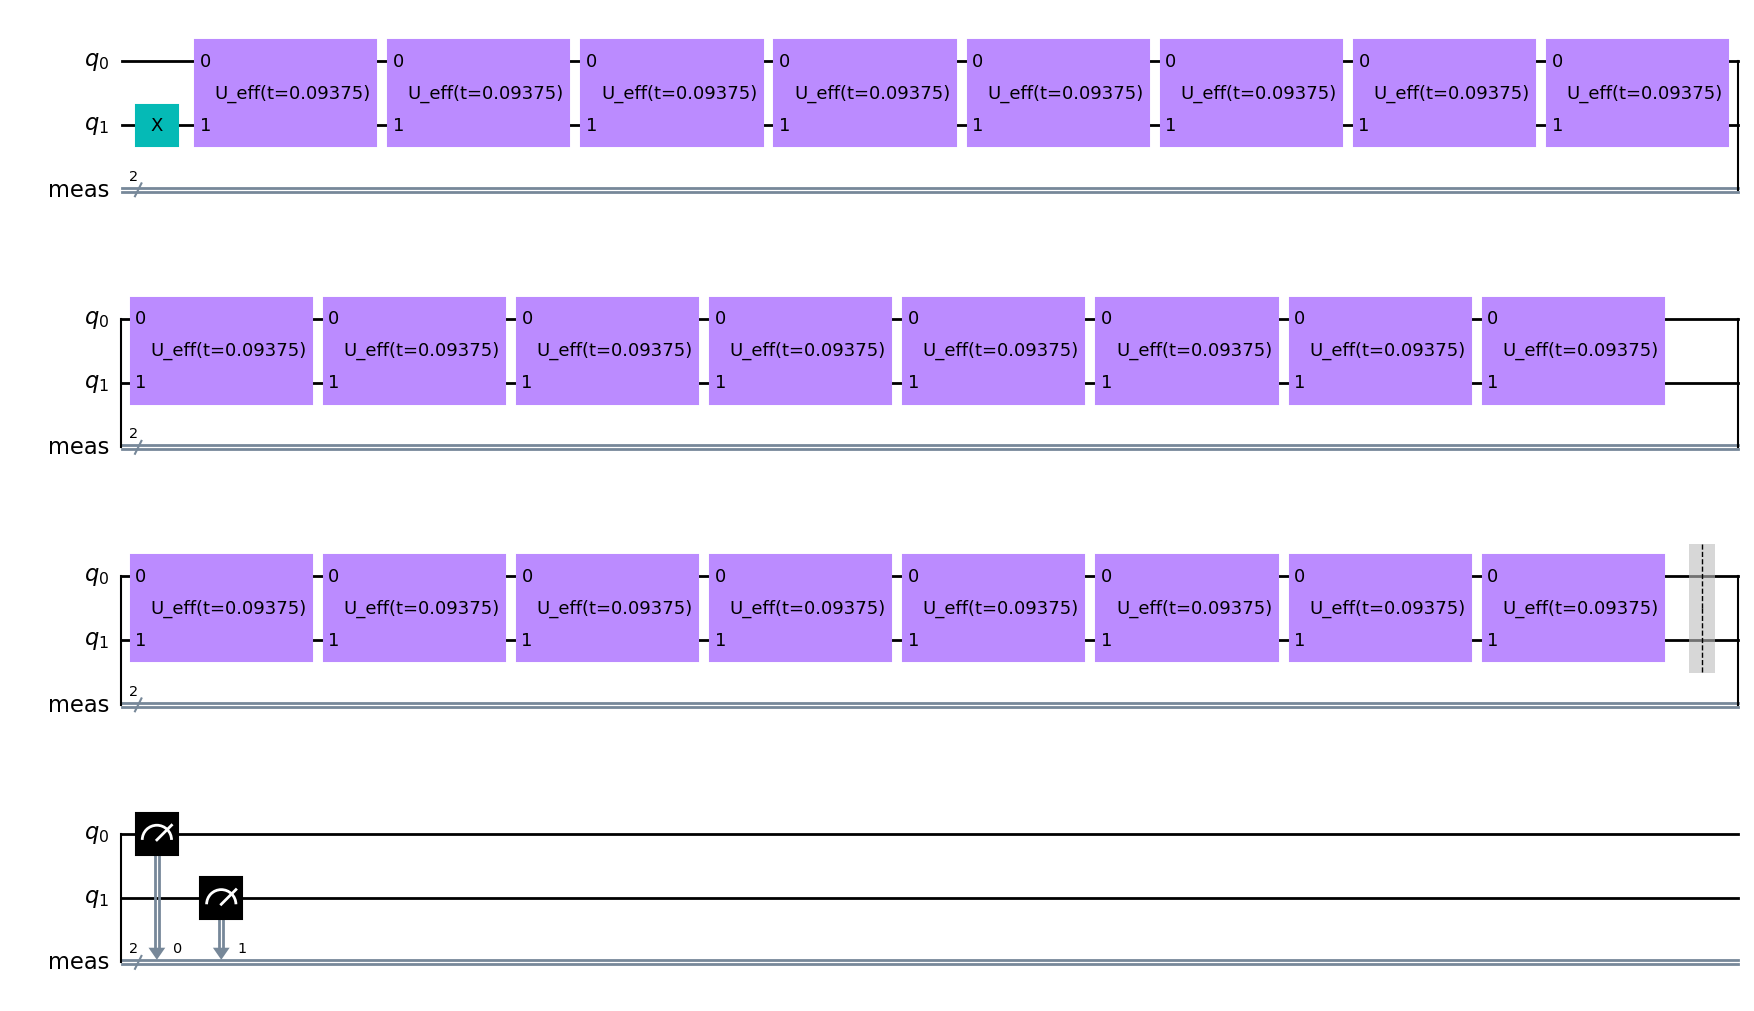

In [21]:
phi = Parameter("phi")
qc = QuantumCircuit(2)

qc.x(1)
for i in range(r):
    qc.append(Rxy(phi), [0,1])
qc.measure_all()

qc.draw(output='mpl')

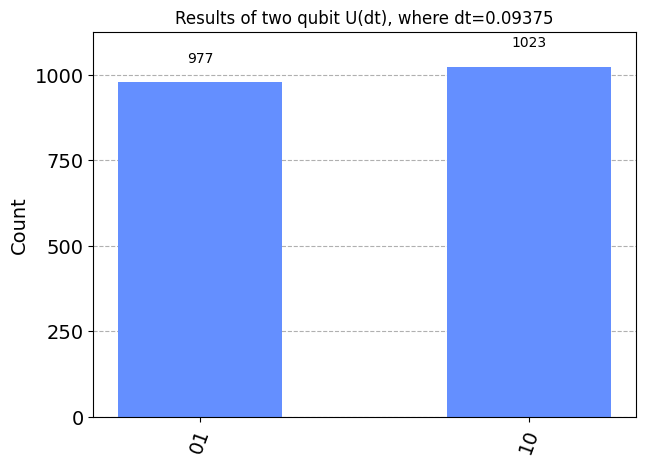

In [22]:
sim = Aer.get_backend('aer_simulator')
shots = 2000
results = execute(qc, backend=sim, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts, title="Results of two qubit U(dt), where dt={}".format(dt))